In [22]:
#Import

#Modelling
import mesa

from mesa import Agent, Model

import solara

#Analysis
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid
from mesa.time import RandomActivation

from mesa.experimental import JupyterViz

import matplotlib.pyplot as plt
from matplotlib.figure import Figure

import pandas as pd

import numpy as np
import random 

In [23]:
from typing import Callable, Optional, Type

class RandomActivationByTypeFiltered(mesa.time.RandomActivationByType):
    """
    A scheduler that overrides the get_type_count method to allow for filtering
    of agents by a function before counting.

    Example:
    >>> scheduler = RandomActivationByTypeFiltered(model)
    >>> scheduler.get_type_count(AgentA, lambda agent: agent.some_attribute > 10)
    """

    def get_type_count(
        self,
        type_class: Type[mesa.Agent],
        filter_func: Optional[Callable[[mesa.Agent], bool]] = None,
    ) -> int:
        """
        Returns the current number of agents of certain type in the queue
        that satisfy the filter function.
        """
        count = 0
        for agent in self.agents_by_type[type_class].values():
            if filter_func is None or filter_func(agent):
                count += 1
        return count

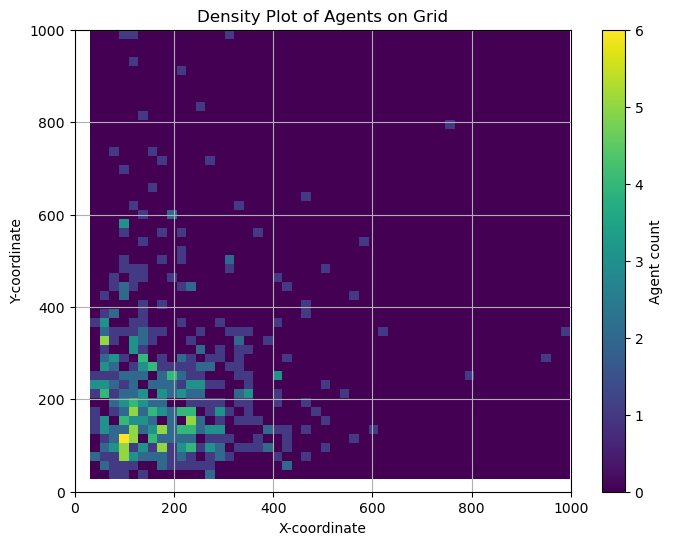

In [39]:
%matplotlib inline
# Function to generate unique coordinates for agents based on lognormal distribution
def generate_coordinates(num_agents, grid_size):
    mu = np.log(500)
    sigma = 0.6

    x_coords = np.random.lognormal(mean=mu, sigma=sigma, size=num_agents)
    y_coords = np.random.lognormal(mean=mu, sigma=sigma, size=num_agents)

    x_coords = (x_coords * grid_size / np.max(x_coords)).astype(int)
    y_coords = (y_coords * grid_size / np.max(y_coords)).astype(int)

    # Ensure coordinates are within grid bounds
    x_coords = np.clip(x_coords, 0, grid_size - 1)
    y_coords = np.clip(y_coords, 0, grid_size - 1)

    # Ensure unique coordinates using numpy unique function
    unique_coordinates, counts = np.unique(np.column_stack((x_coords, y_coords)), axis=0, return_counts=True)
    unique_coordinates = unique_coordinates[:num_agents]  # Take required number of unique coordinates

    return unique_coordinates.tolist()

# Define grid size and number of agents
grid_size = 1000
num_agents = 500

# Generate unique coordinates for agents
agent_coordinates = generate_coordinates(num_agents, grid_size)

# Extract x and y coordinates for plotting
x_coords, y_coords = zip(*agent_coordinates)

# Create a density plot of agent distribution on the grid
plt.figure(figsize=(8, 6))
plt.hist2d(x_coords, y_coords, bins=50, cmap='viridis')
plt.colorbar(label='Agent count')
plt.title('Density Plot of Agents on Grid')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.xlim(0, grid_size)  # Set x-axis limits to match grid size
plt.ylim(0, grid_size)  # Set y-axis limits to match grid size
plt.grid(True)
plt.show()

In [25]:
#Model

class BrainModel(Model):
    def __init__(self, Nn, Na, width, height):
        super().__init__()
        self.num_neurons = Nn
        self.num_antibody = Na
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivationByTypeFiltered(self)
        self.running = True
        self.step_count = 0
        self.datacollector = DataCollector(
            model_reporters={
            "Total surface NMDARs": compute_tot_nmdar,
            "Number of Antibodies": lambda m: m.schedule.get_type_count(AntibAgent)   
        },
        agent_reporters={
            "Surface NMDAR Conc.": "NMDAR",
            "Agent type": "type"
        }, 
    )
        
     # Create Neurons
        neuron_coords = self.generate_coordinates() 

        for unique_id, (x,y) in enumerate(neuron_coords):
            neuron = NeuronAgent((x,y), self)
            self.grid.place_agent(neuron, (x, y))
            self.schedule.add(neuron)

    #Create Antibodies
        for i in range(self.num_antibody):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            
            antib = AntibAgent((i,x,y), self)
            self.grid.place_agent(antib, (x, y))
            self.schedule.add(antib) 

    # Function to generate unique coordinates for agents based on lognormal distribution
    def generate_coordinates(self):
        mu = np.log(self.grid.width / 2)
        sigma = 0.6

        x_coords = np.random.lognormal(mean=mu, sigma=sigma, size=self.num_neurons)
        y_coords = np.random.lognormal(mean=mu, sigma=sigma, size=self.num_neurons)

        x_coords = (x_coords * self.grid.width / np.max(x_coords)).astype(int)
        y_coords = (y_coords * self.grid.height / np.max(y_coords)).astype(int)

        # Ensure coordinates are within grid bounds
        x_coords = np.clip(x_coords, 0, self.grid.width - 1)
        y_coords = np.clip(y_coords, 0, self.grid.height - 1)

        unique_coordinates, counts = np.unique(np.column_stack((x_coords, y_coords)), axis=0, return_counts=True)
        unique_coordinates = unique_coordinates[:self.num_neurons]

        return unique_coordinates.tolist()

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.step_count += 1

        for agent in self.schedule.agents[:]:
            if hasattr(agent, "remove"):
                agent.remove()

#Agents

class NeuronAgent(Agent):
    def __init__(self, unique_id, model):
        # run the __init__ method of the parent class
        super().__init__(unique_id, model)
        # additional initialization for the derived class
        self.NMDAR = 1.2e12 #lognormal distribution?    
        self.type = "Neuron" 

    def step(self):
        if self.model.step_count % random.randint(50,144) == 0 and self.NMDAR < 1.2e12: #is this the right way to do it?
            self.NMDAR += random.randint(0,1)

class AntibAgent(Agent):
    def __init__(self, unique_id, model):
        # run the __init__ method of the parent class
        super().__init__(unique_id, model)
        # additional initialization for the derived class
        self.NMDAR = 0
        self.type = "Antibody"
        self.tau = 120 / np.log(2)     
        self.marked_for_removal = False    

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,  # current position
            moore=True,  # including step on the diagonal
            include_center=False,  # to remain at current position is not allowed
        )
        
        if possible_steps:
            new_position = self.random.choice(possible_steps)
            self.model.grid.move_agent(self, new_position)
            self.pos = new_position

    def step(self):
        self.move()
        p = 1/self.tau #The probability that a given antibody will decay this step
        r = random.random()

        #if there is a neuron nearby, internalise NMDAR
        x, y = self.pos
        this_cell = self.model.grid.get_cell_list_contents([self.pos])
        neuron = [obj for obj in this_cell if isinstance(obj, NeuronAgent)]
        
        if neuron:
             random_number = random.randint(1, 100)
             affected_neuron = self.random.choice(neuron)
             
             if random_number >= 50:
                affected_neuron.NMDAR -= 1

             # Internalise NMDAR, along with itself
             self.marked_for_removal = True #rätt placering?
        
        # antibody decay
        if r < p: 
            self.marked_for_removal = True 

    def remove(self):
        if self.marked_for_removal:
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)


def compute_tot_nmdar(model):
    
    agent_nmdars =  [agent.NMDAR for agent in model.schedule.agents]

    tot = sum(agent_nmdars)

    return tot    


In [26]:
model = BrainModel(500, 200000, 1000, 1000)

for i in range(1500):
    model.step()

In [27]:
agent_df = model.datacollector.get_agent_vars_dataframe()
model_df = model.datacollector.get_model_vars_dataframe()

model_df
agent_df

Surface NMDAR Conc. Agent type
Step AgentID                                           
0    (23, 201)                  1.200000e+12     Neuron
     (26, 189)                  1.200000e+12     Neuron
     (31, 375)                  1.200000e+12     Neuron
     (34, 109)                  1.200000e+12     Neuron
     (36, 104)                  1.200000e+12     Neuron
...                                      ...        ...
1499 (171426, 775, 539)         0.000000e+00   Antibody
     (184117, 364, 507)         0.000000e+00   Antibody
     (190526, 613, 71)          0.000000e+00   Antibody
     (194091, 540, 437)         0.000000e+00   Antibody
     (197860, 700, 536)         0.000000e+00   Antibody

[34102268 rows x 2 columns]

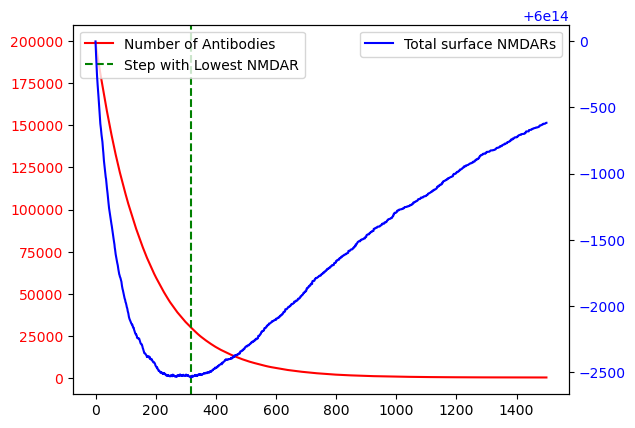

Step with lowest NMDAR concentration: 318


In [28]:
# Find the step with the lowest concentration surface NMDAR
min_step = model_df['Total surface NMDARs'].idxmin()

# Plot the result
fig, ax = plt.subplots()
ax.plot(model_df['Number of Antibodies'], label='Number of Antibodies', color='red')
ax.tick_params(axis='y', labelcolor='red')

ax2 = ax.twinx()
ax2.plot(model_df['Total surface NMDARs'], label='Total surface NMDARs', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax.axvline(x=min_step, color='green', linestyle='--', label='Step with Lowest NMDAR')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# Print the step with the lowest concentration surface NMDAR
print("Step with lowest NMDAR concentration:", min_step)

In [29]:
neuron_df = agent_df.loc[agent_df['Agent type'] == 'Neuron']

neuron_df

Surface NMDAR Conc. Agent type
Step AgentID                                   
0    (23, 201)          1.200000e+12     Neuron
     (26, 189)          1.200000e+12     Neuron
     (31, 375)          1.200000e+12     Neuron
     (34, 109)          1.200000e+12     Neuron
     (36, 104)          1.200000e+12     Neuron
...                              ...        ...
1499 (622, 294)         1.200000e+12     Neuron
     (634, 458)         1.200000e+12     Neuron
     (653, 239)         1.200000e+12     Neuron
     (915, 103)         1.200000e+12     Neuron
     (999, 206)         1.200000e+12     Neuron

[750000 rows x 2 columns]

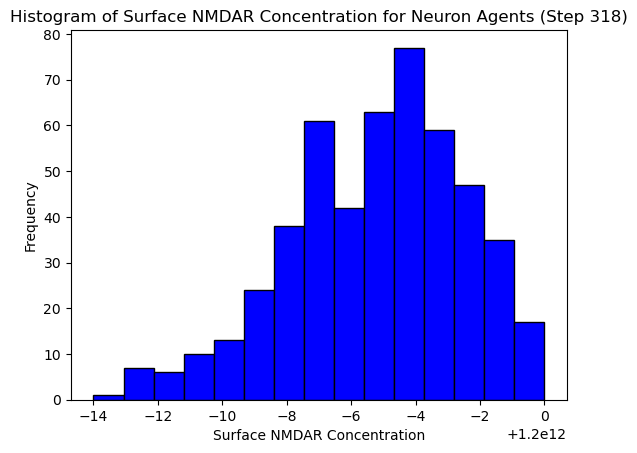

In [30]:
# Find the step with the lowest NMDAR concentration
min_concentration_step = model_df['Total surface NMDARs'].idxmin()

# Filter agent dataframe for the step with the lowest concentration and Neuron agents
neuron_df_min_concentration = agent_df.xs(min_concentration_step, level="Step").loc[agent_df.xs(min_concentration_step, level="Step")['Agent type'] == 'Neuron']

# Plot histogram
plt.hist(neuron_df_min_concentration['Surface NMDAR Conc.'], bins=15, color='blue', edgecolor='black')
plt.xlabel('Surface NMDAR Concentration')
plt.ylabel('Frequency')
plt.title(f'Histogram of Surface NMDAR Concentration for Neuron Agents (Step {min_concentration_step})')
plt.show()

In [31]:
'''
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "Color": "blue",
                 "r": 0.5}
    
    if isinstance(agent, AntibAgent):
        portrayal["Color"] = "red"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.2

    return portrayal

grid = mesa.visualization.CanvasGrid(agent_portrayal, 1000, 1000, 1000, 1000)

nmdar = mesa.visualization.ChartModule([{"Label": "Total surface NMDARs", "Color": "Red"}],
                                       data_collector_name='datacollector')

ab = mesa.visualization.ChartModule([{"Label": "Number of Antibodies", "Color": "Blue"}],
                                       data_collector_name='datacollector')


server = mesa.visualization.ModularServer(
    BrainModel, 
    [grid, nmdar, ab], 
    "Brain Model", 
    {"Nn":100, "Na":40000, "width":1000, "height":1000,}
)

server.port = 8553
server.launch()'''

'\ndef agent_portrayal(agent):\n    portrayal = {"Shape": "circle",\n                 "Filled": "true",\n                 "Layer": 0,\n                 "Color": "blue",\n                 "r": 0.5}\n    \n    if isinstance(agent, AntibAgent):\n        portrayal["Color"] = "red"\n        portrayal["Layer"] = 1\n        portrayal["r"] = 0.2\n\n    return portrayal\n\ngrid = mesa.visualization.CanvasGrid(agent_portrayal, 1000, 1000, 1000, 1000)\n\nnmdar = mesa.visualization.ChartModule([{"Label": "Total surface NMDARs", "Color": "Red"}],\n                                       data_collector_name=\'datacollector\')\n\nab = mesa.visualization.ChartModule([{"Label": "Number of Antibodies", "Color": "Blue"}],\n                                       data_collector_name=\'datacollector\')\n\n\nserver = mesa.visualization.ModularServer(\n    BrainModel, \n    [grid, nmdar, ab], \n    "Brain Model", \n    {"Nn":100, "Na":40000, "width":1000, "height":1000,}\n)\n\nserver.port = 8553\nserver.launch